1. Définir le problème
 

2. Récupérer les données
 

3. Analyser et nettoyer les données
  

4. Préparer les données
  

5. **Evaluer plusieurs modèles**
  

6. Réglage fin des modèles
 

7. Surveiller son modèle

# 📌 5. Evaluer plusieurs modèles : les métriques de performance

## 🚀 Objectif
Dans cette section, nous allons parcourir les **métriques de performances** dédiées à la **classification**.  

## 🔍 Étapes du processus
1. **Importer les bibliothèques nécessaires, charger les données, les séparer en train/test et les transformer**  
2. **Présenter les limites de l'exactitude (Accuracy) en comparant une régression logistique à un classifieur naîf**  
3. **Présenter le principe de la matrice de confusion**    
4. **Afficher des courbes ROC**  
5. **S'attarder sur la problématique du compromis précision/rappel**   
6. **Afficher des courbes de précision rappel**
7. **Faire un bilan**  


In [ ]:
# Import des bibliothèques nécessaires
import warnings  # Pour éviter les warnings inutiles

import numpy as np  # Pour les calculs numériques
import pandas as pd  # Pour la manipulation des données
import matplotlib.pyplot as plt  # Pour la visualisation des résultats
import seaborn as sns  # Pour améliorer l'apparence des graphiques

# Scikit-learn : outils pour la préparation et l'évaluation des modèles
from sklearn.model_selection import (
    train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV
)  # Pour diviser les données, validation croisée et recherche de grille
from sklearn.preprocessing import StandardScaler  # Pour la normalisation des données
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score, roc_curve, accuracy_score,
    ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve, RocCurveDisplay,
    PrecisionRecallDisplay, auc
)  # Pour l'évaluation des performances du modèle
from sklearn.pipeline import Pipeline  # Pour créer des pipelines de traitement
from sklearn.feature_selection import SelectKBest, mutual_info_classif  # Pour la sélection de variables

# Importation des algorithmes de classification
from sklearn.linear_model import LogisticRegression  # Pour la régression logistique
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
)  # Classifieurs basés sur des ensembles d'arbres
from sklearn.svm import SVC  # Pour les machines à vecteurs de support
from sklearn.neural_network import MLPClassifier  # Pour les réseaux de neurones
from sklearn.naive_bayes import GaussianNB  # Pour le classifieur Naive Bayes Gaussien
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  # Pour l'analyse discriminante linéaire
from sklearn.neighbors import KNeighborsClassifier  # Pour le classifieur des k plus proches voisins
from imblearn.under_sampling import RandomUnderSampler  # Pour le sous-échantillonnage des données déséquilibrées
from sklearn.base import BaseEstimator  # Classe de base pour créer des estimateurs personnalisés

warnings.filterwarnings("ignore")  # Désactiver les warnings pour ne pas surcharger l'affichage


## 🔹5.1. Chargement des données
Nous chargeons notre dataset qui contient plusieurs variables explicatives et une variable cible `Echec : 1/0`.


In [ ]:
# Chargement des données
df = pd.read_csv("/content/DataSet_RegionPelvienne_Class.csv", sep=",")
df = df.drop(columns=["Unnamed: 0"])  # Suppression de colonnes inutiles

# Aperçu des données
display(df.head())

### ➡️ Séparation des données en entraînement et test
Nous séparons le dataset en :
- **70% d'entraînement** pour apprendre au modèle.
- **30% de test** pour évaluer ses performances sur des données jamais vues.

### ➡️ Sous-échantillonnage de la classe majoritaire
Nous équilibrons la base pour éviter un déséquilibre qui pourrait biaiser l'entraînement.

### ➡️ Normalisation des variables
Les modèles sensibles aux échelles de variables (**SVM, MLP, Régression Logistique**) nécessitent une normalisation.

In [ ]:
# Séparation des variables explicatives et de la cible
y = df['Echec']
X = df.drop(columns=['Echec'])

# Division des données en entraînement (70%) et test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=2025)

# Sous-échantillonnage de la classe majoritaire pour équilibrer les classes
rus = RandomUnderSampler(sampling_strategy={0: len(y_train[y_train == 1]) * 2, 1: len(y_train[y_train == 1])}, random_state=2025)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

# Normalisation des variables
scaler = StandardScaler()
X_train_res_std = scaler.fit_transform(X_train_res)  # Normalisation des données d'entraînement
X_test_std = scaler.transform(X_test)  # Normalisation des données test

## 🔹 5.2. Les métriques de performance
Lorsqu'on entraîne un modèle de ML, il est essentiel d'évaluer ses performances correctement. Cependant, **toutes les métriques ne sont pas adaptées** à tous les problèmes.

Dans Scikit-Learn, la **métrique par défaut est souvent l'accuracy**. Or, cette métrique peut être trompeuse pour les problèmes de classification en cas de **déséquilibre de classes**.

**Exemple** : Si 90% des exemples appartiennent à la classe 0, un modèle qui prédit toujours 0 aura **90% d'accuracy**, mais il ne détectera jamais la classe minoritaire.



>Nous allons décrire ici les **métriques adaptées à la classification binaire**. D'autres métriques doivent être utilisées si on veut faire de la **classification multiple** ou de la **régression** (prédire directement les valeurs des indices gamma dans notre exemple, au lieu du statut pass/fail).   
Les métriques disponibles dans scikit peuvent être retrouvées ici : 🔗 [Documentation Scikit - Metriques](https://scikit-learn.org/stable/modules/model_evaluation.html)     
Des métriques personnalisées peuvent aussi être créées manuellement : 🔗 [Documentation Scikit - MetriquesPerso](https://scikit-learn.org/stable/developers/develop.html#rolling-your-own-estimator)

### 🔍 Comparaison entre une régression logistique et un classifieur naïf
Nous allons comparer :
1. Une **régression logistique**.
2. Un **classifieur naïf** qui prédit toujours la classe majoritaire.

Nous utiliserons plusieurs **métriques de performance** :
- **Accuracy** : Combien de prédictions sont correctes parmi toutes les prédictions ?
- **Précision** (Precision) : Combien de prédictions positives sont correctes ?
- **AUC-ROC** : Capacité du modèle à distinguer les classes positives et négatives (vrais positifs en fonction des faux positifs). AU-ROC = 1 -> Prédicteur parfait
  


**Exemple avec une régression logistique**

![image.png](https://datatab.fr/assets/tutorial/Logistic-function.png)

La fonction logistique a la capacité de transformer un nombre compris entre – l’infini et + l’infini en un nombre compris entre 0 et 1 qui se comporte comme une probabilité. La régression logistique ne permet de résoudre que des problèmes de classification. 

Vidéo StatQuest qui explique la regression logistique :
🔗 [Video StatQuest - Regression Logistique](https://www.youtube.com/watch?v=yIYKR4sgzI8)


In [ ]:
# Modèle 1 : Régression Logistique
# --------------------------------
# Création d'un modèle de régression logistique standard.
# La régression logistique est un modèle de classification binaire basé sur une fonction logistique.
# Ici, on initialise le modèle avec une graine aléatoire fixée pour garantir la reproductibilité.
clf_lr = LogisticRegression(random_state=2025)

# Entraînement du modèle de régression logistique sur les données normalisées et rééchantillonnées.
# - X_train_res_std : Variables explicatives normalisées
# - y_train_res : Variable cible (échec ou réussite)
clf_lr.fit(X_train_res_std, y_train_res)

# Modèle 2 : Classifieur naïf (prédit toujours la classe majoritaire)
# -------------------------------------------------------------------
# Création d'un classifieur "stupide" qui classe systématiquement toutes les observations
# dans la classe majoritaire (ici, classe 0, correspondant à "réussite").
# - On utilise la classe `BaseEstimator` de Scikit-learn pour rendre ce modèle compatible
#   avec les outils d'évaluation de Scikit-learn (ex: cross-validation).
class TjsReussite(BaseEstimator):
    def fit(self, X, y=None):
        # Pas d'entraînement nécessaire, le modèle ne fait que des prédictions constantes
        pass

    def predict(self, X):
        # Retourne un tableau rempli de 0 (classe majoritaire) de la même taille que X
        return np.zeros(len(X), dtype=int)

# Initialisation du classifieur naïf
clf_stupid = TjsReussite()

# Prédictions sur les données test
# --------------------------------
# Le modèle de régression logistique prédit les classes sur les données test normalisées.
y_pred_lr = clf_lr.predict(X_test_std)

# Le classifieur naïf prédit également les classes sur les mêmes données test.
y_pred_stupid = clf_stupid.predict(X_test_std)

# Calcul des métriques de performance
# -----------------------------------
# Définition d'un dictionnaire contenant plusieurs métriques d'évaluation :
# - "Accuracy" : Exactitude, proportion de prédictions correctes
# - "Précision" : Nombre de prédictions positives correctes sur toutes les prédictions positives
# - "AUC-ROC" : Aire sous la courbe ROC, mesure de la capacité du modèle à distinguer les classes
metrics = {
    "Accuracy": accuracy_score,
    "Précision": precision_score,
    "AUC-ROC": roc_auc_score
}

# Affichage des performances des deux modèles
print("\n📊 Comparaison des modèles")
for metric_name, metric_func in metrics.items():
    # Évaluation de chaque métrique pour la régression logistique et le classifieur naïf
    print(f"{metric_name} (Régression Logistique): {metric_func(y_test, y_pred_lr):.2f}")
    print(f"{metric_name} (Classifieur naïf) : {metric_func(y_test, y_pred_stupid):.2f}\n")

# Interprétation :
# - Si la base de données est très déséquilibrée (ex: 90% de classe 0 et 10% de classe 1),
#   alors un classifieur qui prédit systématiquement la classe 0 peut obtenir une *accuracy* élevée
#   mais une *précision* et un *AUC-ROC* très faibles.
# - L'AUC-ROC est généralement une meilleure mesure que l'accuracy pour évaluer les modèles dans un contexte de classification déséquilibrée.


<font size = 7>⚠️</font>

L'accuracy conduit à **une illusion de performance** si l'on ne regarde pas d'autres métriques.   
Elle est souvent utilisée par défaut dans **Scikit-Learn** pour évaluer les modèles, mais elle peut être trompeuse, surtout en **classification avec classes déséquilibrées**. Si elle est utilisée pour rechercher les hyper-paramètres du modèle cela peut **fausser le choix des hyper-paramètres**. 

### 🔍 Matrice de confusion
Une matrice de confusion permet d'évaluer la qualité des prédictions.
Elle affiche :
- **Vrais positifs (TP)**
- **Faux positifs (FP)**
- **Vrais négatifs (TN)**
- **Faux négatifs (FN)**


<img src="https://miro.medium.com/v2/resize:fit:969/1*d0UCCIF10Soi7VQGxdVrWQ.jpeg" alt="drawing" width="700"/>

In [ ]:
# Matrice de confusion pour la régression logistique
cm_lr = confusion_matrix(y_test, y_pred_lr)
ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=[0, 1]).plot()
plt.title("Matrice de confusion - Régression Logistique")
plt.show()

# Matrice de confusion pour le classifieur naïf
cm_stupid = confusion_matrix(y_test, y_pred_stupid)
ConfusionMatrixDisplay(confusion_matrix=cm_stupid, display_labels=[0, 1]).plot()
plt.title("Matrice de confusion - Classifieur Naïf")
plt.show()

# Matrice de confusion prédictions parfaites
cm_stupid = confusion_matrix(y_test, y_test)
ConfusionMatrixDisplay(confusion_matrix=cm_stupid, display_labels=[0, 1]).plot()
plt.title("Matrice de confusion - Classifieur parfait")
plt.show()

A partir de la matrice de confusion on a accès à différentes métriques : 

🔢 **Notations :**
- **TP (True Positives)** : Nombre de cas positifs (fail) correctement détectés.
- **TN (True Negatives)** : Nombre de cas négatifs (pass) correctement détectés.
- **FP (False Positives)** : Nombre de cas négatifs (pass) incorrectement détectés comme positifs (fail).
- **FN (False Negatives)** : Nombre de cas positifs (fail) incorrectement détectés comme négatifs (pass).
- **P (Positifs réels)** : $ P = TP + FN $ (*total des vrais positifs (fail)*).
- **N (Négatifs réels)** : $ N = TN + FP $ (*total des vrais négatifs (pass)*).

---

 📈 **Formules des métriques**

| **Métrique**                          | **Formule**                          | **Interprétation** |
|----------------------------------------|:--------------------------------------:|--------------------|
| **Probabilité de fausse alarme** (*False Positive Rate - FPR*) | $ \text{FPR} = \frac{FP}{N} = 1 - \text{TNR} $ | Proportion de cas négatifs incorrectement détectés comme positifs. |
| **Taux d'échec** (*False Negative Rate - FNR*) | $ \text{FNR} = \frac{FN}{P} = 1 - \text{TPR} $ | Proportion de cas positifs incorrectement détectés comme négatifs. |
| **Sensibilité** (*Rappel / True Positive Rate - TPR*) | $ \text{TPR} = \frac{TP}{P} = 1 - \text{FNR} $ | Proportion de cas positifs correctement détectés. |
| **Spécificité** (*True Negative Rate - TNR*) | $ \text{TNR} = \frac{TN}{N} = 1 - \text{FPR} $ | Proportion de cas négatifs correctement détectés. |
| **Précision** (*Positive Predictive Value - PPV*) | $ \text{PPV} = \frac{TP}{TP + FP} = 1 - \text{FDR} $ | Proportion de cas positifs correctement détectés parmi toutes les détections positives. |
| **Taux de fausses découvertes** (*False Discovery Rate - FDR*) | $ \text{FDR} = \frac{FP}{TP + FP} = 1 - \text{PPV} $ | Proportion de fausses détections parmi toutes les détections positives. |
| **Exactitude** (*Accuracy*) | $ \text{Accuracy} = \frac{TP + TN}{P + N} $ | Proportion de prédictions correctes parmi l’ensemble des cas. |

---


In [ ]:
# Extraction des valeurs de la matrice de confusion
TN, FP, FN, TP = cm_lr.ravel()


<font size = 4><span style="color:#2980b9"> **1️⃣ Sensibilité ou Rappel (Recall, Taux de vrais positifs, TPR - True Positive Rate)** </span></font>


   - **Définition** : Proportion de cas positifs correctement détectés par le modèle.  
   - **Formule** :  
     $$
     \text{Rappel} = \frac{TP}{TP + FN}
     $$
   - **Intérêt** : Utile lorsque l’objectif est de **minimiser les faux négatifs**, par exemple en **détection de maladies**.



In [ ]:
# calcul de la sensibilité (ou rappel) à partir du tableau de la matrice de confusion cm[ligne][colonne]
TPR = TP/(TP+FN)*100
print("Le modèle détecte %0.0f%% des échecs sur les données test." %TPR)

On peut aussi utiliser la fonction scikit : 

In [ ]:
recall_score(y_test, y_pred_lr)

<font size = 4><span style="color:#2980b9"> **2️⃣ Spécificité (Taux de vrais négatifs, TNR - True Negative Rate)** </span></font>


   - **Définition** : Proportion de cas négatifs correctement détectés.  
   - **Formule** :  
     $$
     \text{Spécificité} = \frac{TN}{TN + FP}
     $$
   - **Intérêt** : Important lorsque **minimiser les faux positifs** est crucial, comme en **détection de fraudes**.



In [ ]:
# calcul de la spécificité
TNR = TN/(FP+TN)*100
print("Le modèle détecte %0.0f%% des réussites sur les données test." %TNR)

<font size = 4><span style="color:#2980b9"> **3️⃣ Précision (PPV - Positive Predictive Value)** </font></span>


   - **Définition** : Proportion de cas prédits positifs qui sont réellement positifs.  
   - **Formule** :  
     $$
     \text{Précision} = \frac{TP}{TP + FP}
     $$
   - **Intérêt** : Crucial lorsque **minimiser les fausses alertes est essentiel**, comme en **filtrage anti-spam**.

In [ ]:
# calcul de la précision
PPV = TP / (TP + FP)*100
print("Parmis les échecs détectés sur les données test, %0.0f%% sont corrects." %PPV)

On peut aussi utiliser la fonction scikit : 

In [ ]:
precision_score(y_test, y_pred_lr)

### 🔍 Courbes ROC (Receiver Operating Characteristic)
- **Courbe ROC** : Montre le taux de faux positifs (FPR) vs. le taux de vrais positifs (TPR).


<img src="https://abdatum.com/media/images/curva-roc.png" alt="drawing" width="700"/>

<font size = 3>**Aire Sous la Courbe ROC (AUROC)**   </font>   


L’AUROC (AUC-ROC) est une mesure synthétique de performance :
- **AUROC = 1** : Modèle parfait.
- **AUROC = 0.5** : Modèle aléatoire.
- **AUROC < 0.5** : Modèle inversé (il prédit mieux les négatifs que les positifs).


<font size = 3> 🎯 **Pourquoi utiliser la courbe ROC ?**   </font>   


✔️ **Indépendante du seuil** de décision utilisé.  
✔️ **Utile sur des bases déséquilibrées**, contrairement à l’accuracy.  
✔️ **Permet de comparer plusieurs modèles** en fonction de leur capacité de discrimination.  


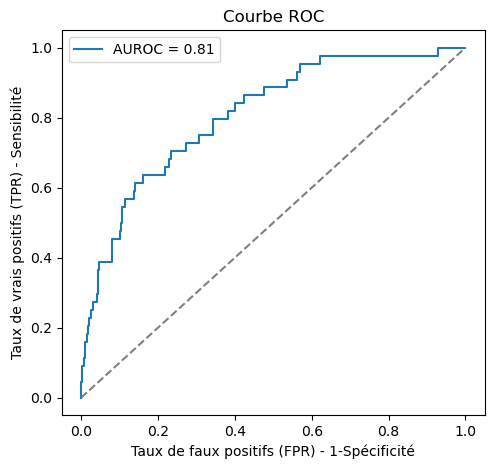

In [25]:
# Probabilités de prédiction de la classe 1
# -----------------------------------------
# La plupart des modèles de classification binaire (comme la régression logistique)
# retournent des probabilités d'appartenance à chaque classe.
# Ici, on récupère la probabilité d'appartenir à la classe positive (classe 1).
# predict_proba() retourne un tableau à deux colonnes :
# - La première colonne correspond à la probabilité d'appartenir à la classe 0.
# - La deuxième colonne correspond à la probabilité d'appartenir à la classe 1.
# Nous sélectionnons uniquement la colonne de la classe positive (index 1).
y_scores_lr = clf_lr.predict_proba(X_test_std)[:, 1]

# Calcul des courbes ROC
# ----------------------
# La fonction roc_curve() calcule le taux de faux positifs (FPR) et le taux de vrais positifs (TPR)
# pour différents seuils de classification.
# Ces valeurs permettent de tracer la courbe ROC (Receiver Operating Characteristic).
# _ représente les seuils de décision (que l'on n'affiche pas ici).
fpr, tpr, _ = roc_curve(y_test, y_scores_lr)

# Tracé de la courbe ROC
# ----------------------
plt.figure(figsize=(12,5))  # Création d'une figure avec une largeur de 12 et hauteur de 5

# Création du premier sous-graphique (1 ligne, 2 colonnes, premier graphique)
plt.subplot(1,2,1)

# Tracé de la courbe ROC : taux de vrais positifs (TPR) en fonction du taux de faux positifs (FPR)
plt.plot(fpr, tpr, label=f"AUROC = {roc_auc_score(y_test, y_scores_lr):.2f}")

# Ajout d'une ligne diagonale en pointillés (classifieur aléatoire, AUROC = 0.5)
plt.plot([0,1], [0,1], linestyle='--', color='grey')

# Ajout des labels et titre
plt.xlabel("Taux de faux positifs (FPR) - 1-Spécificité")
plt.ylabel("Taux de vrais positifs (TPR) - Sensibilité")
plt.title("Courbe ROC")

# Ajout de la légende affichant la valeur de l'AUROC (aire sous la courbe)
plt.legend()

# Affichage de la figure
plt.show()


<font size = 6>ℹ️</font>    
On peut aussi tracer la courbe ROC directement à l'aide de la fonction `RocCurveDisplay()` de scikit : 

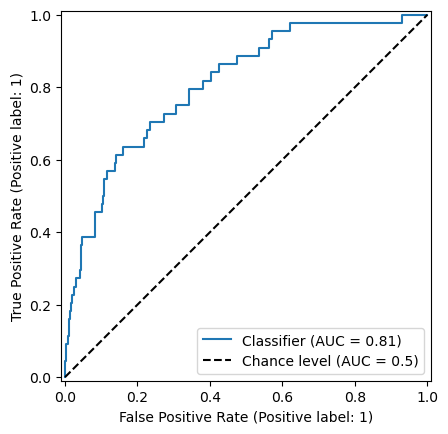

In [28]:
RocCurveDisplay.from_predictions(y_test, y_scores_lr, plot_chance_level = True)

<font size = 5>⚠️</font>

Attention quand on trace la courbe ROC ou qu'on calcule l'aire sous la courbe, il faut toujours utiliser les probabilités prédites d'appartenir à la classe positive et pas les étiquettes prédites directement ! L'erreur est facile à faire (ex : on utilise `predict()` au lieu de `predict_proba()`) et les fonctions scikit ne renverront pas d'erreur.  

### 🔍 Compromis entre précision et rappel


<img src="https://miro.medium.com/v2/resize:fit:824/0*faCzwVWg5RLqAj1J.png" alt="drawing" width="600"/>

Dans une classification binaire, la majorité des classifieurs ne prennent pas directement une décision, mais attribuent d’abord à chaque observation un **score** ou une **probabilité** d’appartenance à la classe positive (ex: "échec" dans un problème de détection).  

<font size = 4><span style="color:#2980b9"> **Décision basée sur un seuil** </span></font>    
Ce score est ensuite comparé à un **seuil de décision** pour attribuer une classe :
- Si le score est **supérieur** au seuil → l'observation est classée dans la classe positive.
- Sinon → elle est classée dans la classe négative.

<font size = 4><span style="color:#2980b9"> **Impact du seuil sur la précision et le rappel** </span></font>      
Le choix du seuil influence directement les prédictions :
- **Un seuil bas** entraîne plus de prédictions positives. Cela **augmente le rappel** ( $\frac{TP}{TP + FN}$) mais **réduit la précision** (on commet plus de faux positifs).
- **Un seuil élevé** entraîne moins de prédictions positives. Cela **augmente la précision** ($\frac{TP}{TP + FP}$), mais **diminue le rappel** (plus de vrais positifs sont manqués).

<font size = 4><span style="color:#2980b9"> **Illustration du compromis** </span></font>      
- Un seuil **très bas** : presque toutes les observations sont classées comme positives → **rappel élevé, précision faible**.
- Un seuil **très haut** : seules les observations avec un score très fort sont classées positives → **précision élevée, rappel faible**.

<font size = 4>💡 **Choisir le bon seuil dépend des objectifs du problème** :   </font>
- Si **les faux négatifs sont coûteux** (ex: diagnostic médical), on privilégie un **rappel élevé**.
- Si **les faux positifs sont critiques** (ex: filtrage anti-spam), on favorise une **précision élevée**.
- Dans certains cas, on utilise des métriques combinées comme le **score F1** pour équilibrer les deux.

👉 **Le tracé de la courbe Précision-Rappel et de la courbe ROC aide à choisir un seuil optimal selon le contexte.** 

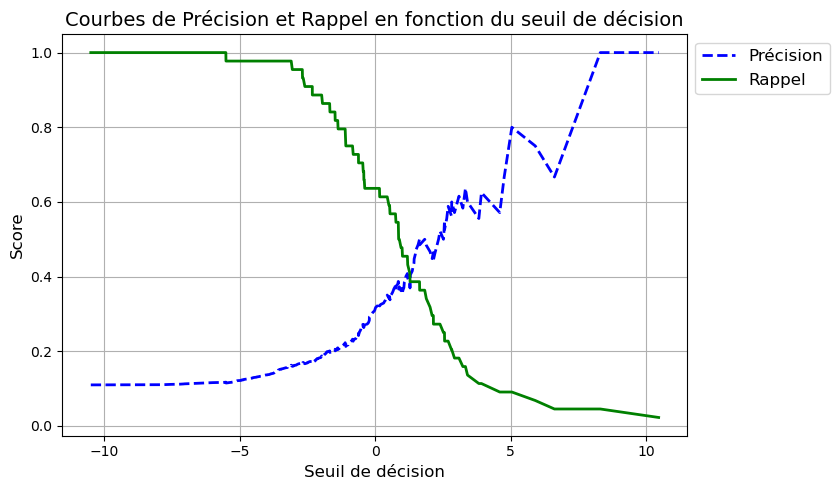

In [29]:
# Calcul des scores de décision pour les données test
# decision_function() retourne un score continu pour chaque observation
# Plus le score est élevé, plus le modèle est confiant que l'exemple appartient à la classe positive
y_scores = clf_lr.decision_function(X_test_std)

# Calcul des précisions et rappels pour différents seuils de décision
# precision_recall_curve() retourne trois éléments :
# - precisions : liste des précisions obtenues à chaque seuil
# - recalls : liste des rappels obtenus à chaque seuil
# - thresholds : liste des seuils testés (longueur = nombre de points - 1)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Création d'une figure pour tracer les courbes
plt.figure(figsize=(10, 5))  # Définition de la taille de la figure

# Tracé de la courbe de précision en fonction du seuil
plt.plot(thresholds, precisions[:-1], "b--", label="Précision", linewidth=2)

# Tracé de la courbe de rappel en fonction du seuil
plt.plot(thresholds, recalls[:-1], "g-", label="Rappel", linewidth=2)

# Ajout des axes et d'un titre explicatif
plt.xlabel("Seuil de décision", fontsize=12)  # Axe des x : valeurs du seuil
plt.ylabel("Score", fontsize=12)  # Axe des y : valeurs de précision/rappel
plt.title("Courbes de Précision et Rappel en fonction du seuil de décision", fontsize=14)

# Ajout d'une grille pour une meilleure lisibilité
plt.grid(True)

# Placement de la légende en dehors de la figure
# - bbox_to_anchor=(1,1) permet de placer la légende à l'extérieur de la figure
# - loc="upper left" positionne la légende dans le coin supérieur gauche de la zone d'affichage externe
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=12)

# Ajustement des marges pour éviter que la légende ne coupe la figure
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Affichage de la figure
plt.show()


<font size = 6>ℹ️</font>    



La courbe de **précision** est **irrégulière**. Cela arrive si, en augmentant le seuil, il se trouve qu'on n'augmente pas le nombre de faux positifs mais uniquement celui de faux négatifs. Etant donné que le nombre de prédits positifs diminue quand on augmente le seuil de décision, on peut se retrouver avec des variations importantes de la précision car le rapport entre vrai positifs et prédits positifs peut varier dans un sens comme dans l'autre.      
Le rappel diminue forcément avec l'augmentation du seuil car le nombre de réellement positifs est toujours le même alors que les prédits positifs diminuent forcément si on augmente le seuil de décision.  

><font size = 6>⚠️</font>  
>
>Dans Scikit-Learn, `predict_proba()` et `decision_function()` sont deux méthodes utilisées pour obtenir un score de confiance sur les prédictions d'un modèle de classification. Cependant, elles diffèrent dans leur sortie et leur utilisation.   
> - `predict_proba()` retourne les probabilités d'appartenance aux différentes classes, comprises entre 0 et 1   
> - `decision_function()` retourne le score brut de la fonction de décision utilisée en interne par l'algorithme. Les valeurs ne pas bornées, elles peuvent être négatives et très grandes. Plus la valeur est grande plus le modèle est confiant sur l'appartenance à la classe positive. Si le score est >0 c'est la classe positive qui est prédite, s'il est <0 c'est la classe négative.   
> - Comme `predict_proba()`retourne des valeurs comprises entre 0 et 1, cela peut écraser la distribution des scores, rendant moins précise la détermination du seuil adequat pour ajuster le compromis précision/rappel.  

<div class="alert alert-block alert-info">
<b>Application </b> Impact du seuil de décision sur le rappel et la précision : </div> 

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Calcul des scores de décision pour les données test
# decision_function() retourne un score continu pour chaque observation
# Plus le score est élevé, plus le modèle est confiant que l'exemple appartient à la classe positive
y_test_scores = clf_lr.decision_function(X_test_std)

# Définition du widget interactif pour ajuster le seuil de décision
threshold_slider = widgets.FloatSlider(
    value=0.5,  # Seuil initial à 0.5
    min=-10,
    max=10,
    step=1,
    description="Seuil",
    continuous_update=True
)

# Widget d'affichage des résultats
output = widgets.Output()

def update_threshold(threshold):
    """Met à jour la précision et le rappel en fonction du seuil sélectionné."""
    with output:
        clear_output(wait=True)  # Nettoie l'affichage précédent
        
        # Appliquer le seuil pour générer les prédictions binaires
        y_pred_thresholded = (y_test_scores >= threshold).astype(int)
        
        # Calcul des métriques avec gestion des erreurs
        precision = precision_score(y_test, y_pred_thresholded, zero_division=0)
        recall = recall_score(y_test, y_pred_thresholded)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresholded).ravel()
        specificity = tn / (tn + fp)
        
        # Affichage des résultats
        print(f"🔹 Seuil de décision (valeur brute de la fonction de décision) : {threshold:.2f}")
        
        print(f"🔸 Précision : {precision:.2f}")
        print(f"🔸 Rappel/Sensibilité : {recall:.2f}")

        # Tracé des courbes Précision et Rappel en fonction du seuil
        thresholds = np.linspace(-10, 10, 21)
        precisions = [precision_score(y_test, (y_test_scores >= t).astype(int), zero_division=0) for t in thresholds]
        recalls = [recall_score(y_test, (y_test_scores >= t).astype(int)) for t in thresholds]

        plt.figure(figsize=(8, 5))
        plt.plot(thresholds, precisions, label="Précision", color="blue")
        plt.plot(thresholds, recalls, label="Rappel", color="green")
        plt.axvline(threshold, color="red", linestyle="--", label=f"Seuil = {threshold:.2f}")
        plt.xlabel("Seuil de décision")
        plt.ylabel("Valeur")
        plt.title("Impact du seuil de décision sur la précision et le rappel")
        plt.legend()
        plt.grid(True)
        plt.show()

# Lier le widget au callback
widgets.interactive(update_threshold, threshold=threshold_slider)

# Affichage des widgets
display(threshold_slider, output)


### 🔍 Courbe Précision-Rappel (PR)


La **courbe Précision-Rappel (PR)** est une représentation graphique de la relation entre **la précision ($\frac{TP}{TP + FP}$) et le rappel ( $\frac{TP}{TP + FN}$)** pour différents seuils de décision d'un modèle de classification binaire.


<font size = 3><span style="color:#2980b9"> **Comment interpréter la courbe PR ?**  </span></font>
- Un modèle **idéal** aura une précision et un rappel élevés, donc sa courbe PR sera **proche du coin supérieur droit**.
- Une **courbe plus haute** signifie un **meilleur compromis** entre la précision et le rappel.
- La **baseline** est la proportion d’exemples positifs dans l’ensemble des données : si un modèle prédit uniquement la classe positive, il aura cette précision moyenne.

<font size = 3><span style="color:#2980b9"> **Pourquoi utiliser la courbe PR ?**   </span>  </font> 


✔ **Meilleure évaluation pour les bases de données déséquilibrées** :  
   - Contrairement à la courbe ROC, qui inclut le taux de faux positifs (FPR), la courbe PR est **plus informative** lorsque la classe positive est minoritaire.  
   - Si une classe est rare, **une faible FPR ($\frac{FP}{N} $) peut être trompeuse**, car elle ne reflète pas bien la capacité du modèle à détecter les vrais positifs.  

✔ **Utile pour ajuster le seuil de décision** :  
   - En fonction de l’application, on peut privilégier **plus de rappel (moins de faux négatifs)** ou **plus de précision (moins de faux positifs)**.

✔ **Évaluation globale avec l'aire sous la courbe (AUPRC - Average Precision Score)** :  
   - Comme l'AUC-ROC, **l'aire sous la courbe PR (AUPRC)** permet de comparer facilement plusieurs modèles.


In [ ]:
# Calcul des scores de décision pour les données test
# decision_function() retourne un score continu pour chaque observation
# Plus le score est élevé, plus le modèle est confiant que l'exemple appartient à la classe positive
y_scores = clf_lr.decision_function(X_test_std)

# Calcul des précisions et rappels pour différents seuils de décision
# precision_recall_curve() retourne trois éléments :
# - precisions : liste des précisions obtenues à chaque seuil
# - recalls : liste des rappels obtenus à chaque seuil
# - thresholds : liste des seuils testés (longueur = nombre de points - 1)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)


# Calcul de l'aire sous la courbe PR (AUPRC)
auprc = auc(recalls, precisions)

# Création de la figure
plt.figure(figsize=(8,6))

# Tracé de la courbe Précision-Rappel
plt.plot(recalls, precisions, label=f"LR AUPRC = {auprc:.2f}", color="blue", linewidth=2)

# Ajout d'une ligne de base correspondant à la proportion de la classe positive dans les données test
baseline = np.sum(y_test) / len(y_test)
plt.plot([0, 1], [baseline, baseline], linestyle='--', color='grey', label=f"Baseline AUPRC = {baseline:.2f}")

# Ajout des titres et labels
plt.xlabel("Rappel (Recall)")
plt.ylabel("Précision (Precision)")
plt.title("Courbe Précision-Rappel")
plt.legend(loc="upper right")

# Ajout d'une grille pour faciliter la lecture du graphique
plt.grid(True)

# Affichage du graphique
plt.show()


<font size = 6>ℹ️</font>    
On peut aussi tracer la courbe PR directement à l'aide de la fonction `PrecisionRecallDisplay()` de scikit :

In [ ]:
PrecisionRecallDisplay.from_predictions(y_test, y_scores, plot_chance_level = True)

## 📌 Bilan sur les métriques de classification

En classification, plusieurs **métriques d'évaluation** permettent d'analyser les performances d'un modèle. Chaque métrique a ses avantages et ses limites, et leur choix dépend souvent du **contexte du problème** et de la distribution des classes.

---

 **1️⃣ Accuracy (Exactitude)**   
- Proportion de bonnes prédictions parmi l’ensemble des observations.
- **Avantage** : Facile à interpréter.
- **Limite** : Peu pertinent en cas de **déséquilibre des classes** (ex : un modèle qui classe tout en négatif peut avoir une haute accuracy mais être inutile).

📌 **Formule** :  
$$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$

---

 **2️⃣ Matrice de confusion**   
- Table récapitulant les **vrais positifs (TP)**, **faux positifs (FP)**, **vrais négatifs (TN)** et **faux négatifs (FN)**.

|               | Prédiction Positif | Prédiction Négatif |
|--------------|-------------------|-------------------|
| **Réel Positif (P)**  | TP (Vrai Positif)  | FN (Faux Négatif) |
| **Réel Négatif (N)**  | FP (Faux Positif)  | TN (Vrai Négatif) |

---

 **3️⃣ Précision (Precision)**   
- Proportion de prédictions positives qui sont réellement positives.
- **Avantage** : Évite les **faux positifs**, utile si les **erreurs positives sont coûteuses** (ex : détection de fraude).
- **Limite** : Ignore les **faux négatifs**.

📌 **Formule** :  
$$
Precision = \frac{TP}{TP + FP}
$$

---

 **4️⃣ Rappel (Recall ou Sensibilité)**   
- Proportion de cas positifs réellement détectés.
- **Avantage** : Utile si l'on veut **minimiser les faux négatifs** (ex : diagnostic médical).
- **Limite** : Ignore les **faux positifs**.

📌 **Formule** :  
$$
Recall = \frac{TP}{TP + FN}
$$

---

 **5️⃣ Score F1**   
- Moyenne harmonique entre **précision et rappel**.
- **Avantage** : Bon **compromis entre précision et rappel** si les deux sont importants.
- **Limite** : Ne reflète pas bien les déséquilibres de classe.

📌 **Formule** :  
$$
F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}
$$

---

 **6️⃣ Courbe ROC & AUROC**   
- La **courbe ROC** (Receiver Operating Characteristic) trace **le taux de vrais positifs (TPR)** en fonction du **taux de faux positifs (FPR)**.
- AUROC proche de **1** → Excellent modèle, proche de **0.5** → Modèle aléatoire.

- **Avantages** : Utile si l'on veut **analyser le compromis** entre sensibilité et spécificité.  

- **Limite** : Peu fiable en cas de **déséquilibre des classes**.

---

 **7️⃣ Courbe Précision-Rappel (PR) & AUPRC**   
- Utile lorsque **la classe positive est rare**.
- Permet d'observer **l'évolution de la précision et du rappel** en fonction du seuil de décision.
- **AUPRC** (Aire sous la courbe Précision-Rappel) est une alternative à l'AUC-ROC.

- **Avantages** : Plus adaptée aux **problèmes avec classes déséquilibrées**.  

- **Limite** :  Moins intuitive que la courbe ROC.

---

 **🔹 Comment choisir la bonne métrique ?**   
| Objectif | Métrique recommandée |
|----------|---------------------|
| Classes équilibrées | **Accuracy, AUC-ROC** |
| Détection des positifs importants | **Rappel (Recall), Courbe PR, AUPRC** |
| Minimiser les faux positifs | **Précision (Precision)** |
| Compromis entre précision et rappel | **Score F1** |
| Visualisation globale | **Matrice de confusion, ROC, PR** |

---

✅ **Toujours comparer plusieurs métriques avant de choisir un modèle final**


> **Métriques d’évaluation pour la régression**
>
>En régression, les métriques mesurent l’écart entre les valeurs **prédites** et les valeurs **réelles**. 
>
>| **Métrique** | **Définition** | **Avantages** | **Inconvénients** |
>|-------------|--------------|--------------|--------------|
>| **Erreur absolue moyenne (MAE)** | Moyenne des écarts absolus entre prédictions et valeurs réelles. | Facile à interpréter, robuste aux outliers. | Ne pénalise pas fortement les grosses erreurs. |
>| **Erreur quadratique moyenne (MSE)** | Moyenne des écarts au carré entre prédictions et valeurs réelles. | Pénalise fortement les grosses erreurs, utile pour ajuster un modèle. | Sensible aux outliers, les grandes erreurs sont amplifiées. |
>| **Racine de l’erreur quadratique moyenne (RMSE)** | Racine carrée du MSE, exprimée dans la même unité que la variable cible. | Facile à interpréter, pénalise fortement les grandes erreurs. | Peut être trop sensible aux outliers. |
>| **Coefficient de détermination (R²)** | Indique la proportion de variance expliquée par le modèle. | Permet de comparer facilement les modèles. | Peut être trompeur si les données sont non linéaires ou bruitées. |


